<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B28_3%5D_Saliency_Map_using_Keras_vis_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Saliency Map dengan Keras-vis

Sekarang kita akan gunakan library keras-vis untuk memvisualisasikan Saliency Map dan Attention Activation grad-CAM

Seperti sebelumnya, kita harus install ulang library ini langsung dari sourcenya.

In [1]:
!pip install git+https://github.com/raghakot/keras-vis.git

  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-c3t57pzy
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-c3t57pzy
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38885 sha256=9b425ab9906249596421e7133c3522e46cf87bb44497995a97babb7261af137a
  Stored in directory: /tmp/pip-ephem-wheel-cache-x7qusaub/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


## Import Library

In [2]:
import numpy as np
from vis.utils import utils
from keras import activations

import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

Using TensorFlow backend.


## Load Pretraining Model

Di sini mari kita unduh bobot pretraining model VGG16

In [3]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=True)
model.summary()

W0807 02:04:19.767066 140346191628160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 02:04:19.811768 140346191628160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 02:04:19.818143 140346191628160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 02:04:19.856767 140346191628160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 16s 0us/step


W0807 02:04:37.266330 140346191628160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0807 02:04:37.267762 140346191628160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Swap Activation

In [4]:
layer_idx = utils.find_layer_idx(model, 'predictions')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Load Image
Pertama, mari kita unduh beberapa gambar untuk menguji proses Saliency Map ini

Seperti sebelumnya, kita akan fokus menggunakan labek kelas burung `ouzel` di kelas=20 dari label ImageNet

Berikut kita unduh 2 gambar burung ouzel

In [5]:
!wget 'https://raw.githubusercontent.com/raghakot/keras-vis/master/examples/vggnet/images/ouzel1.jpg'
!wget 'https://raw.githubusercontent.com/raghakot/keras-vis/master/examples/vggnet/images/ouzel2.jpg'

--2019-08-07 02:04:57--  https://raw.githubusercontent.com/raghakot/keras-vis/master/examples/vggnet/images/ouzel1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130988 (128K) [image/jpeg]
Saving to: ‘ouzel1.jpg’

ouzel1.jpg          100%[===================>] 127.92K  --.-KB/s    in 0.01s   

2019-08-07 02:04:57 (9.99 MB/s) - ‘ouzel1.jpg’ saved [130988/130988]

--2019-08-07 02:04:59--  https://raw.githubusercontent.com/raghakot/keras-vis/master/examples/vggnet/images/ouzel2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147411 (1

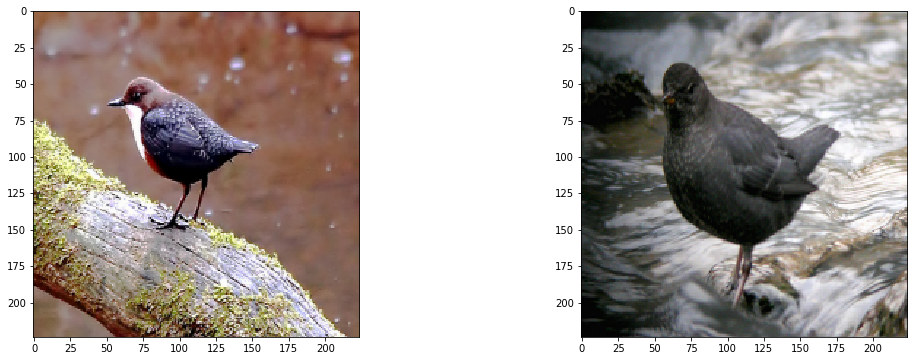

In [6]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('ouzel1.jpg', target_size=(224, 224))
img2 = utils.load_img('ouzel2.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

## Raw Saliency Map

Berikutnya kita lakukan proses Backpropagation untuk mendapatkan Saliency Map berupa gradien input yang mengaktifkan kelas `ouzel`

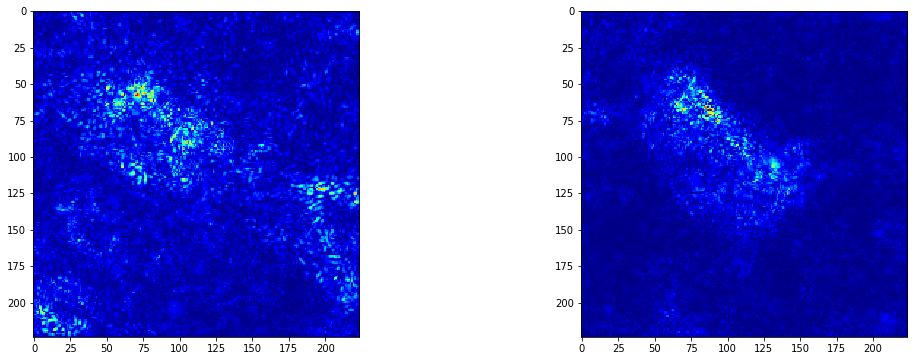

In [7]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

Dapat dilihat bahwa hasil Saliency Map sangatlah kasar (*noisy*) dan tidak jelas

untuk menanganinya, diperkenalkanlah proses Guided Backpropagation

## Guided Backpropagation Saliency Map

Pada proses Guided Backpropagation, hanya gradien dari neuron yang aktif yang dikembalikan

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


<Figure size 1296x432 with 0 Axes>

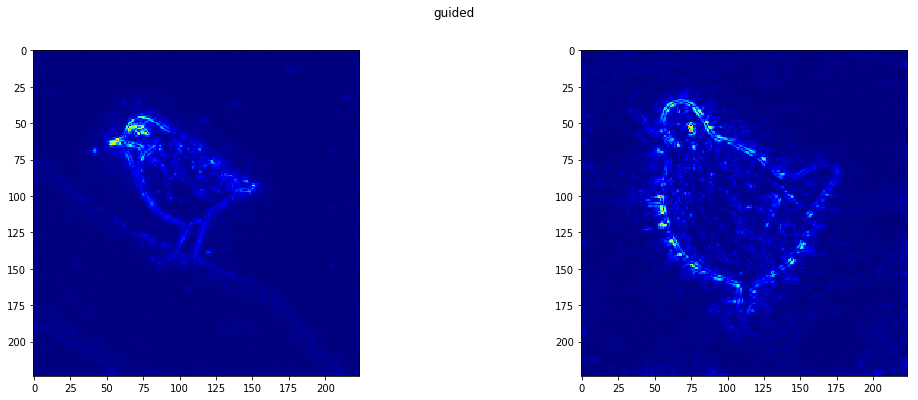

In [8]:
plt.figure()
f, ax = plt.subplots(1, 2)
plt.suptitle('guided')
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=20, 
                               seed_input=img, backprop_modifier='guided')
    # Lets overlay the heatmap onto original image.    
    ax[i].imshow(grads, cmap='jet')

Dapat dilihat bahwa sekarang hasil Saliency Map jauh lebih terfokus ke bagian apa yang mengklasifikasikan kelas `ouzel`

## grad-CAM

grad-CAM Saliency Map adalah proses untuk menggambarkan heatmap fokus (*attention*) bagian input gambar yang mengaktivasi kelas yang dituju 

<Figure size 1296x432 with 0 Axes>

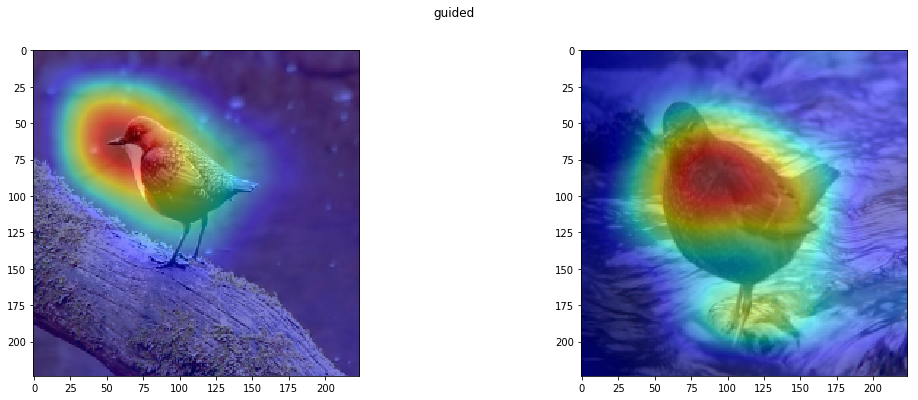

In [9]:
from vis.visualization import visualize_cam

plt.figure()
f, ax = plt.subplots(1, 2)
plt.suptitle('guided')
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_cam(model, layer_idx, filter_indices=20, 
                          seed_input=img, backprop_modifier='guided')        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    ax[i].imshow(overlay(jet_heatmap, img))

Bagaimana hasil visualisasinya?

Cobalah bermain-main dan menampilkan Saliency Map kelas lain dengan data gambar baru

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>